# 基于标签的简易个性化推荐算法

一个用户标签行为的数据集一般由一个三元组的集合表示，其中记录$(u, i, b)$表示用户$u$给物品$i$打上了标签$b$。当然，用户的真实标签行为数据远远比三元组表示的要复杂，比如用户打标签 的时间、用户的属性数据、物品的属性数据等。

## 1 算法简介
### 1.1 Simple Tag Based
$u$代表用户，$i$代表"物品"
- 统计每个用户的常用标签
- 对每个标签，统计被打过这个标签次数最多的商品
- 对于某一个具体用户，找到他最常用的标签，将这些标签最热门的物品推荐给他
- 排序推荐

得分公式如下:
$$ score(u,~i)= \sum_t{UserTags[u,t]~*~TagItems[t,i]}$$
其中$UserTags[u,t]$表示用户$u$使用过标签$t$的次数, $TagItems[t,i]$表示商品$i$被打过标签$t$的次数
### 1.2 NormTagBased
这个算法是对 Simple Tag Based 算法得分进行归一化:
$$ score(u,~i)= \sum_t{\frac{UserTags[u,t]}{UserTags[u]}~*~\frac{TagItems[t,i]}{TagItems[t]}} $$
### 1.3 TagBased-TFIDF
如果一个tag很热门，会导致$UserTags[t]$很大，所以即使$TagItems[u,t]$很小，也会导致$score(u,i)$很大，因此会造成推荐热门的物品给用户，从而降低推荐结果的新颖性。另外，这个公式利用用户的标签向量对用户兴趣建模，其中 每个标签都是用户使用过的标签，而标签的权重是用户使用该标签的次数。这种建模方法的缺点 是给热门标签过大的权重，从而不能反应用户个性化的兴趣。这里我们可以借鉴TF-IDF的思想， 对这一公式进行改进，用$TagUser[t]$表示标签$t$被多少个不同的用户使用：
$$ score(u,~i)= \sum_t{\frac{UserTags[u,t]}{log(1+TagUsers[t])}*TagItems[t,i]}$$

## 2 实践

In [41]:
# 使用SimpleTagBased算法对Delicious数据集进行推荐
# 原始数据集：https://grouplens.org/datasets/hetrec-2011/
# 数据格式：userID     bookmarkID     tagID     timestamp

In [42]:
# 初始化

import pandas as pd
import warnings


warnings.filterwarnings('ignore')

# 数据集地址
file_path = '../data/hetrec2011-delicious-2k/user_taggedbookmarks-timestamps.dat'
# 采用字典格式，保存user对item的tag，{user：{item1:[tag1,rag2]...}...}
records = {}
# 训练集、测试集
train_data = {}
test_data = {}
# 用户标签，商品标签
user_tags = dict()
user_items = dict()
tag_items = dict()
tag_user = dict()

In [43]:
# 数据加载
def load_data():
    print('数据正在加载中...')
    df = pd.read_csv(file_path,sep = '\t')
    #将df放入设定的字典格式中
    for i in range(len(df)):
    #for i in range(10):
        uid = df['userID'][i]
        iid = df['bookmarkID'][i]
        tag = df['tagID'][i]
        #setdefault将uid设置为字典，iid设置为[]
        records.setdefault(uid,{})
        records[uid].setdefault(iid,[])
        records[uid][iid].append(tag)
    #print(records)
    print('数据集大小为：%d.' %len(df))
    print('设置tag的人数:%d.' %len(records))
    print('数据加载完成\n')

In [44]:
import random
# 将数据集拆分为训练集及测试集,ratio为测试集划分比例
def train_test_split(ratio,seed = 100):
    random.seed(seed)
    for u in records.keys():
        for i in records[u].keys():
            #ratio为设置的比例
            if random.random()<ratio:
                test_data.setdefault(u,{})
                test_data[u].setdefault(i,[])
                for t in records[u][i]:
                    test_data[u][i].append(t)
            else:
                train_data.setdefault(u,{})
                train_data[u].setdefault(i,[])
                for t in records[u][i]:
                    train_data[u][i].append(t)
    print("训练集user数为：%d，测试集user数为：%d." % (len(train_data),len(test_data)))

In [45]:
# 设置矩阵mat[index,item]，来储存index与item 的关系, = {index:{item:n}},n为样本个数
def addValueToMat(mat,index,item,value = 1):
    if index not in mat:
        mat.setdefault(index,{})
        mat[index].setdefault(item,value)
    else:
        if item not in mat[index]:
            mat[index].setdefault(item,value)
        else:
            mat[index][item] += value

In [46]:
# 使用训练集,初始化user_tags,user_items,tag_items，/user_tags为{user1：{tags1:n}}
# {user1：{tags2:n}}...{user2：{tags1:n}}，{user2：{tags2:n}}....n为样本个数等
# user_items为{user1:{items1:n}}......原理同上
# tag_items为{tag1:{items1:n}}......原理同上
def initStat():
    records = train_data
    for u,items in records.items():
        for i,tags in records[u].items():
            for tag in tags:
                # users和tag的关系矩阵
                addValueToMat(user_tags,u,tag,1)
                # users和item的关系
                addValueToMat(user_items,u,i,1)
                # tag和item的关系
                addValueToMat(tag_items,tag,i,1)
                # tag和user的关系
                addValueToMat(tag_user,tag,u,1)
    print('user_tags,user_items,tag_items初始化完成.')

In [47]:
import operator
import math

# 对某一用户user进行topN推荐
def recommend(user, N, method='simple'):
    recommend_item = dict()
    tagged_items = user_items[user]
    user_tags_u = sum(user_tags[user].values())
    for tag,utn in user_tags[user].items():
        tag_items_t = sum(tag_items[tag].values())
        for item,tin in tag_items[tag].items():
            # 如果某一user已经给某一item打过标签，则不推荐
            if item in tagged_items:
                continue

            score = utn * tin
            if method == 'norm':
                score = score / (user_tags_u * tag_items_t)
            elif method == 'tfidf':
                score = score / math.log(1 + len(tag_user[tag]))

            if item not in recommend_item:
                recommend_item[item] = score
            else:
                recommend_item[item] = recommend_item[item] + score
    # 按value值，从大到小排序
    return sorted(recommend_item.items(), key=operator.itemgetter(1), reverse=True)[0:N]

In [48]:
# 使用测试集，计算准确率和召回率
def precisionAndRecall(N, method='simple'):
    hit = 0
    h_recall = 0
    h_precision = 0
    for user,items in test_data.items():
        if user not in train_data:
            continue
        rank = recommend(user,N, method)
        for item,rui in rank:
            if item in items:
                hit = hit+1
        h_recall = h_recall +len(items)
        h_precision = h_precision+N

    #返回准确率和召回率
    return (hit/(h_precision*1.0)), (hit/(h_recall*1.0))

In [49]:
#使用test_data对推荐结果进行评估
def testRecommend(nList, method='simple'):
    print(method + ' 方法推荐结果评估如下：')
    print("%3s %10s %10s" % ('N', "精确率", '召回率'))
    precisionList = []
    recallList = []
    for n in nList:
        precision,recall = precisionAndRecall(n, method)
        precisionList.append(precision * 100)
        recallList.append(recall * 100)
        print("%3d %10.3f%% %10.3f%%" % (n, precision * 100, recall * 100))
    return precisionList, recallList

数据正在加载中...
数据集大小为：437593.
设置tag的人数:1867.
数据加载完成

训练集user数为：1860，测试集user数为：1793.
user_tags,user_items,tag_items初始化完成.
simple 方法推荐结果评估如下：
  N        精确率        召回率
 10      0.633%      0.542%
 20      0.512%      0.877%
 30      0.429%      1.103%
 40      0.381%      1.304%
 50      0.345%      1.476%
 60      0.318%      1.635%
 70      0.298%      1.783%
 80      0.276%      1.893%
 90      0.267%      2.056%
100      0.248%      2.124%
norm 方法推荐结果评估如下：
  N        精确率        召回率
 10      0.526%      0.451%
 20      0.412%      0.705%
 30      0.340%      0.872%
 40      0.293%      1.002%
 50      0.269%      1.150%
 60      0.244%      1.256%
 70      0.231%      1.385%
 80      0.225%      1.544%
 90      0.217%      1.673%
100      0.214%      1.831%
tfidf 方法推荐结果评估如下：
  N        精确率        召回率
 10      0.761%      0.652%
 20      0.549%      0.940%
 30      0.454%      1.165%
 40      0.402%      1.376%
 50      0.361%      1.544%
 60      0.328%      1.687%
 70      0.311%      1.

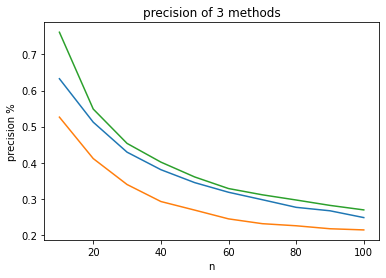

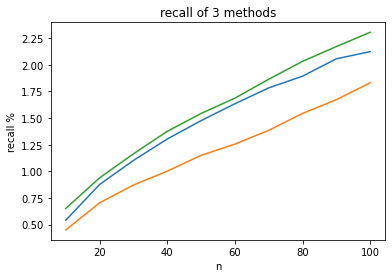

In [50]:
import matplotlib.pyplot as plt


load_data()
train_test_split(0.2)
initStat()
n_list = [10,20,30,40,50,60,70,80,90,100]
simple_precision_list, simple_recall_list = testRecommend(n_list, method='simple')
norm_precision_list, norm_recall_list = testRecommend(n_list, method='norm')
tfidf_precision_list, tfidf_recall_list = testRecommend(n_list, method='tfidf')


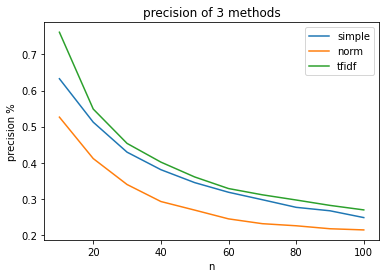

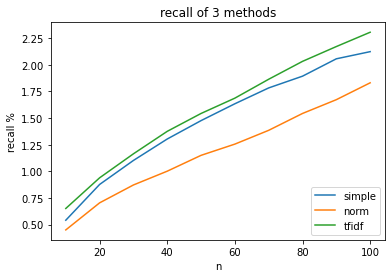

In [54]:
# 绘制精度统计图
plt.plot(n_list, simple_precision_list, label='simple')
plt.plot(n_list, norm_precision_list, label='norm')
plt.plot(n_list, tfidf_precision_list, label='tfidf')
plt.xlabel('n')
plt.ylabel('precision %')
plt.title('precision of 3 methods')
plt.legend(loc=1)
plt.show()

# 绘制召回统计图
plt.plot(n_list, simple_recall_list, label='simple')
plt.plot(n_list, norm_recall_list, label='norm')
plt.plot(n_list, tfidf_recall_list, label='tfidf')
plt.xlabel('n')
plt.ylabel('recall %')
plt.title('recall of 3 methods')
plt.legend(loc=4)
plt.show()